In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
import glob
import PIL
import cv2
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import silhouette_visualizer

Idee:

We hebben een grote dataset van allemaal foto's gedownload van het internet. Deze bevatten foto's van bars, buffets, restaurants, keukens van restaurants, fastfood restaurants, eetzalen, wijnkelders, ...

We proberen een multi-class classifier te maken die 3 dingen kan onderscheiden:
- 1. Het binnendecor van het restaurant --> dus alles van binnen dat geen eten is
- 2. Het eten zelf
- 3. Overige (hoogstwaarschijnlijk zullen dat foto's van de buitenomgeving zijn (gevels, terras, ...))

Dit kan bijvoorbeeld handig zijn wanneer tripadvisor hun app zo wil ontwikkelen dat gebruikers een filter kunnen instellen wanneer ze een restaurant opzoeken. Die filter laat de gebruikers toe om bijvoorbeeld enkel foto's van het eten te tonen, of enkel foto's van het binnendecor te tonen (bv. handig wanneer een koppeltje op zoek is naar een romatische setting en minder aandacht heeft voor hoe het eten eruit ziet).


In [2]:
images_food = []
food_folders = ["Images/buffet/*.jpg", 
                "Images/food/*.jpg"]

# putting all images in a dict where the key is the name of the picture
for folder in food_folders:
    fileNameList = glob.glob(folder)
    for fileName in tqdm(fileNameList, total=len(fileNameList)):
        try:
            img = Image.open(f"{fileName}")
            img = img.resize((128,128))
            img_np = np.array(img).flatten()
            images_food.append(img_np / 255)
        except PIL.UnidentifiedImageError:
            pass

100%|██████████| 28377/28377 [02:52<00:00, 164.94it/s]


In [16]:
images_interior = []
interior_folders = ["Images/restaurant/*.jpg", 
                    "Images/restaurant_kitchen/*.jpg", 
                    "Images/dining_room/*.jpg", 
                    "Images/bar/*.jpg",
                    "Images/fastfood_restaurant/*.jpg"]

for folder in interior_folders:
    fileNameList = glob.glob(folder)
    for fileName in tqdm(fileNameList, total=len(fileNameList)):
        try:
            img = Image.open(f"{fileName}")
            img = img.resize((128,128))
            img_np = np.array(img).flatten()
            images_interior.append(img_np / 255)
        except PIL.UnidentifiedImageError:
            pass

100%|██████████| 116/116 [00:01<00:00, 79.49it/s]


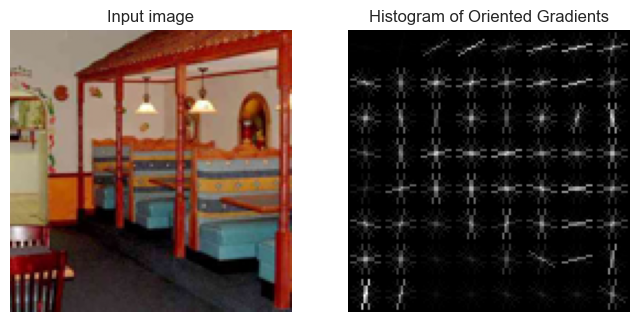

In [18]:
# HOG features example

img = images_interior[50].reshape((128,128,3))

fd, hog_image = hog(img,orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [33]:
# HOG features for all interior images

images_interior = np.array(images_interior)

images_interior_hogs = np.zeros((images_interior.shape[0], 512 * 3))

for i, img in tqdm(enumerate(images_interior), total=len(images_interior)):

    if len(img) != 49152:
        continue
    
    img = img.reshape((128,128,3))
    for channel in range(3):
        fd = hog(img[:,:,channel] ,orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        images_interior_hogs[i, channel*512:channel*512+512] = fd

100%|██████████| 1613/1613 [00:13<00:00, 123.39it/s]


In [35]:
# HOG features for all food images

images_food = np.array(images_food)

images_food_hogs = np.zeros((images_food.shape[0], 512 * 3))

for i, img in tqdm(enumerate(images_food), total=len(images_food)):
    if len(img) != 49152:
        continue
    
    img = img.reshape((128,128,3))
    for channel in range(3):
        fd = hog(img[:,:,channel] ,orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        images_food_hogs[i, channel*512:channel*512+512] = fd


/var/folders/4l/gsvsrpxd2kqb4f6v1wy203b80000gn/T/ipykernel_873/3069977432.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_food = np.array(images_food)
100%|██████████| 28488/28488 [05:04<00:00, 93.47it/s] 


In [40]:
df_interior = pd.DataFrame(images_interior_hogs)
# add a column (in the beginning) with the label "interior"
df_interior.insert(0, "label", "interior")

df_food = pd.DataFrame(images_food_hogs)
# add a column (in the beginning) with the label "food"
df_food.insert(0, "label", "food")

df = pd.concat([df_interior, df_food], ignore_index=True)

# shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

df.head(20)

,label,0,1,2,3,4,5,6,7,8,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,interior,0.503582,0.172271,0.103995,0.503582,0.503582,0.231885,0.278514,0.259580,0.477705,...,0.305824,0.207965,0.391952,0.242245,0.391952,0.391952,0.391952,0.391952,0.299199,0.289253
1,food,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.392626,...,0.494053,0.494053,0.694060,0.087895,0.000000,0.000000,0.137578,0.000000,0.099538,0.694060
2,food,0.379863,0.379863,0.321533,0.175621,0.379863,0.379863,0.379863,0.379863,0.358233,...,0.026520,0.026028,0.556690,0.556690,0.556690,0.018772,0.091060,0.030542,0.056046,0.239940
3,food,0.359231,0.119420,0.213915,0.430455,0.430455,0.430455,0.430455,0.264133,0.154127,...,0.141579,0.136157,0.384690,0.384690,0.384690,0.384690,0.384690,0.282234,0.180070,0.384690
4,food,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.319961,0.223682,0.366972,0.300621,0.366972,0.366972,0.366972,0.318776,0.366972,0.366972
5,food,0.390856,0.390856,0.390856,0.227827,0.390856,0.324690,0.390856,0.280763,0.454295,...,0.022534,0.024291,0.487872,0.487872,0.487872,0.487872,0.214910,0.016623,0.014505,0.035379
6,interior,0.333821,0.195026,0.293977,0.390924,0.390924,0.390924,0.390924,0.390924,0.236732,...,0.375241,0.375241,0.382459,0.332631,0.189632,0.349315,0.382459,0.382459,0.382459,0.382459
7,food,0.417459,0.285569,0.417459,0.417459,0.417459,0.417459,0.194926,0.095373,0.239708,...,0.156274,0.191047,0.355841,0.355841,0.355841,0.355841,0.355841,0.355841,0.337108,0.355841
8,food,0.054752,0.530372,0.530372,0.349495,0.530372,0.126429,0.098384,0.072867,0.363257,...,0.358978,0.312959,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553
9,food,0.569544,0.569544,0.569544,0.071432,0.085964,0.019902,0.052409,0.105937,0.415070,...,0.061241,0.047011,0.546640,0.546640,0.546640,0.087097,0.304992,0.011488,0.026539,0.045942
